<a href="https://colab.research.google.com/github/LEDazzio01/Simplest-Conformal-Prediction/blob/main/20250405-cpb-p-values-and-nc-scores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conformal Prediction Basics: Understanding p-values and Nonconformity Scores

This notebook delves into the fundamental concepts of conformal prediction: p-values and nonconformity scores. We'll implement these concepts from scratch using Python and visualize how they're used to construct prediction sets with guaranteed coverage.  This builds on the basic conformal prediction example, and starts to address model misspecification.

**Key Concepts:**

* **Nonconformity Score:** A measure of how "strange" a new data point is compared to the calibration data, *according to our model*.
* **p-value:** The probability of observing a nonconformity score as large as, or larger than, the score of our test point, *under the assumption that the test point's label is correct*.
* **Prediction Set:** A set of possible labels for a test point, constructed to guarantee a certain coverage probability (1 - alpha).

**Goal:**

1.  Implement nonconformity scores and p-value calculation from scratch.
2.  Visualize the relationship between nonconformity scores, p-values, and prediction sets.
3.  Understand how conformal prediction provides valid inference *regardless* of the underlying model's accuracy.



In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from typing import Callable, Optional, Tuple, List, Union

In [12]:
# --- Code Cell: Load and Preprocess Data ---
def load_and_split_data(test_size: float = 0.3, random_state: int = 42) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, StandardScaler]:
    iris = load_iris()
    X, y = iris.data, iris.target

    # Train-Calibration-Test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_train, X_calibration, y_train, y_calibration = train_test_split(X_train, y_train, test_size=0.5, random_state=random_state)

    # Feature scaling (important for many models)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_calibration = scaler.transform(X_calibration)
    X_test = scaler.transform(X_test)

    return X_train, X_calibration, X_test, y_train, y_calibration, y_test, scaler # Return the fitted scaler

# Load data and get the scaler
X_train, X_calibration, X_test, y_train, y_calibration, y_test, scaler = load_and_split_data()

## 1. Nonconformity Score: Measuring Strangeness

We need a way to quantify how "unusual" a test point is compared to the calibration data. This is the role of the nonconformity score.  A higher nonconformity score means the point is considered more unusual.

For classification, a common nonconformity score is simply related to the probability assigned to the true class by our model.  We'll use:

`Nonconformity Score = 1 - Probability(True Class)`

This score makes intuitive sense:

* If the model is very confident in the correct class (probability close to 1), the nonconformity score is low (the point is "conforming").
* If the model is unsure or assigns low probability to the correct class, the nonconformity score is high (the point is "nonconforming").


In [13]:
# --- Code Cell: Implement Nonconformity Score ---
def nonconformity_score(model: object, X: np.ndarray, y: np.ndarray) -> np.ndarray:
    probabilities = model.predict_proba(X)
    # Get the probability of the true class for each data point
    true_class_probabilities = probabilities[np.arange(len(y)), y]
    # Nonconformity score: 1 - probability of the true class
    return 1 - true_class_probabilities

## 2. Train a Classification Model

We'll use a simple Logistic Regression model for our example.  Conformal prediction works with *any* model, but we need one to generate probabilities.


In [14]:
# --- Code Cell: Train Logistic Regression ---
# Train a logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)



## 3. Calculate Nonconformity Scores on the Calibration Set

Now, let's calculate the nonconformity scores for our calibration data.  These scores are crucial; they form the basis for determining the threshold for our prediction sets.


In [15]:
# --- Code Cell: Calculate Calibration Scores ---
# Calculate nonconformity scores for the calibration set
calibration_scores = nonconformity_score(model, X_calibration, y_calibration)

## 4. The Empirical p-value: Quantifying Strangeness for a New Point

The p-value measures how "strange" a new test point is *relative* to the calibration data.

For a new test point, we calculate its nonconformity score.  The p-value is the proportion of calibration points with a nonconformity score *greater than or equal to* the test point's score.

Mathematically:

`p-value(x_test, y_potential) = (Number of calibration points with score >= nonconformity_score(x_test, y_potential) + 1) / (Number of calibration points + 1)`

The "+ 1" in the numerator and denominator ensures that the p-value is always defined, even if the test point's nonconformity score is higher than all calibration scores.


In [16]:
# --- Code Cell:  Implement p-value Calculation ---
def calculate_p_value(test_score: float, calibration_scores: np.ndarray) -> float:
    # Number of calibration scores greater than or equal to the test score
    greater_equal_scores = np.sum(calibration_scores >= test_score)
    # Empirical p-value
    return (greater_equal_scores + 1) / (len(calibration_scores) + 1)

## 5. Constructing Prediction Sets

Given a desired confidence level (1 - alpha), we form a prediction set for a test point as follows:

For each possible label `y_potential`:

1.  Calculate the nonconformity score of the test point *assuming* `y_potential` is the correct label.
2.  Calculate the p-value using the calibration scores.
3.  Include `y_potential` in the prediction set if its p-value is greater than or equal to `alpha`.

The prediction set is the collection of all `y_potential` values that satisfy this condition.


In [17]:
# --- Code Cell:  Construct Prediction Set ---
def create_prediction_set(model: object, X_test: np.ndarray, y_labels: np.ndarray, calibration_scores: np.ndarray, alpha: float = 0.1) -> List[List[int]]:
    prediction_sets = []
    for x_test in X_test:
        # Initialize an empty set for this test point
        current_prediction_set = []
        for y_potential in y_labels:
            # Need to reshape x_test to (1, n_features) for the nonconformity_score function
            x_test_reshaped = x_test.reshape(1, -1)
            # Calculate the nonconformity score assuming y_potential is the true label
            test_score = nonconformity_score(model, x_test_reshaped, np.array([y_potential]))[0]
            # Calculate the p-value
            p_value = calculate_p_value(test_score, calibration_scores)
            # Include the label in the prediction set if the p-value is >= alpha
            if p_value >= alpha:
                current_prediction_set.append(y_potential)
        prediction_sets.append(current_prediction_set)
    return prediction_sets

# Get all possible labels from the training data
y_labels = np.unique(y_train)
# Create prediction sets for the test data
alpha = 0.1  # 90% coverage
prediction_sets = create_prediction_set(model, X_test, y_labels, calibration_scores, alpha)

## 6. Evaluating Coverage

A key property of conformal prediction is that it guarantees a certain level of coverage.  Specifically, for a given `alpha`, the true label should be in the prediction set at least `(1 - alpha) * 100%` of the time.

Let's check if our implementation achieves this guarantee.


In [18]:
# --- Code Cell:  Evaluate Coverage ---
def evaluate_coverage(prediction_sets: List[List[int]], y_test: np.ndarray) -> float:
    correct_predictions = 0
    for i, y_true in enumerate(y_test):
        if y_true in prediction_sets[i]:
            correct_predictions += 1
    return correct_predictions / len(y_test)

coverage = evaluate_coverage(prediction_sets, y_test)
print(f"Coverage: {coverage:.3f}")
print(f"Desired coverage: {1 - alpha}")

Coverage: 0.956
Desired coverage: 0.9


## 7. Visualizing p-value Distribution (Optional)

It can be helpful to visualize the distribution of p-values, especially for the *correct* labels.  Ideally, these p-values should be roughly uniform between 0 and 1.  Deviations from uniformity can sometimes indicate issues with the model or the exchangeability assumption.


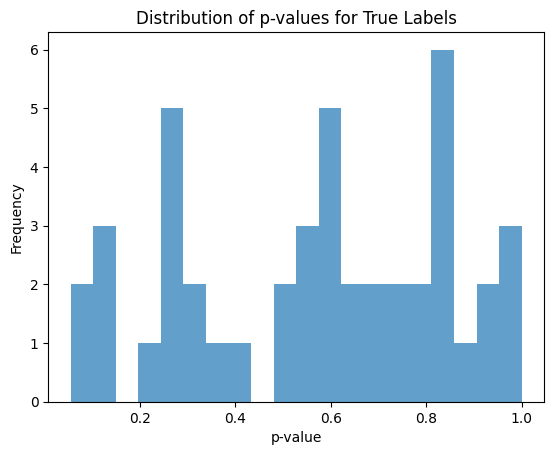

In [19]:
# --- Code Cell: Visualize p-value Distribution ---
def plot_p_value_distribution(model: object, X_test: np.ndarray, y_test: np.ndarray, calibration_scores: np.ndarray) -> None:
    p_values = []
    for i, x_test in enumerate(X_test):
        x_test_reshaped = x_test.reshape(1, -1)
        # Calculate the nonconformity score for the true label
        test_score = nonconformity_score(model, x_test_reshaped, np.array([y_test[i]]))[0]
        p_value = calculate_p_value(test_score, calibration_scores)
        p_values.append(p_value)

    plt.hist(p_values, bins=20, alpha=0.7)
    plt.xlabel("p-value")
    plt.ylabel("Frequency")
    plt.title("Distribution of p-values for True Labels")
    plt.show()

plot_p_value_distribution(model, X_test, y_test, calibration_scores)

## 8. Example Prediction Sets

Let's look at a few examples of the prediction sets generated by our conformal predictor.


In [20]:
# --- Code Cell: Print Example Prediction Sets ---

def print_example_prediction_sets(prediction_sets: List[List[int]], X_test_scaled: np.ndarray, scaler: StandardScaler, y_test: np.ndarray, target_names: List[str], num_examples: int = 5) -> None:
    print("Example Prediction Sets:")
    # Get original feature values by inverting the scaling for the examples we want to show
    X_test_original = scaler.inverse_transform(X_test_scaled[:num_examples])

    for i in range(min(num_examples, len(prediction_sets))):
        original_features = X_test_original[i] # Use the inverse transformed features
        feature_str = ", ".join([f"{name}: {value:.2f}" for name, value in zip(load_iris().feature_names, original_features)])
        print(f"Test point {i+1} - Features: {feature_str}, True Label: {target_names[y_test[i]]}, Prediction Set: {[target_names[label] for label in prediction_sets[i]]}")

# Get target names for Iris dataset.
target_names = load_iris().target_names.tolist()
# Pass the scaled X_test and the fitted scaler to the function
print_example_prediction_sets(prediction_sets, X_test, scaler, y_test, target_names)

Example Prediction Sets:
Test point 1 - Features: sepal length (cm): 6.10, sepal width (cm): 2.80, petal length (cm): 4.70, petal width (cm): 1.20, True Label: versicolor, Prediction Set: ['versicolor']
Test point 2 - Features: sepal length (cm): 5.70, sepal width (cm): 3.80, petal length (cm): 1.70, petal width (cm): 0.30, True Label: setosa, Prediction Set: ['setosa']
Test point 3 - Features: sepal length (cm): 7.70, sepal width (cm): 2.60, petal length (cm): 6.90, petal width (cm): 2.30, True Label: virginica, Prediction Set: ['virginica']
Test point 4 - Features: sepal length (cm): 6.00, sepal width (cm): 2.90, petal length (cm): 4.50, petal width (cm): 1.50, True Label: versicolor, Prediction Set: ['versicolor']
Test point 5 - Features: sepal length (cm): 6.80, sepal width (cm): 2.80, petal length (cm): 4.80, petal width (cm): 1.40, True Label: versicolor, Prediction Set: ['versicolor']


## Discussion and Conclusion

This notebook demonstrated the core mechanics of conformal prediction:

1.  We calculated nonconformity scores to measure the "strangeness" of data points.
2.  We used these scores to compute empirical p-values, quantifying the likelihood of observing a score as extreme as the test point's score.
3.  We constructed prediction sets by including all labels whose p-values met our desired confidence level (1 - alpha).

Key Takeaways:

* Conformal prediction provides *guaranteed coverage* regardless of the underlying model's accuracy.  The calibration data informs us about the model's errors.
* The choice of nonconformity score is crucial.  It should reflect how well the model's prediction aligns with the observed data.
* The p-value is a fundamental quantity that allows us to convert nonconformity into a probabilistic statement about the plausibility of different labels.

Next Steps:

* Experiment with different nonconformity scores.
* Explore how the choice of `alpha` affects the size and coverage of the prediction sets.
* Investigate conformal prediction with different machine learning models.
